In [1]:
# see http://icsdweb.aegean.gr/awid for more info

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


2022-06-30 16:24:51.279863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 16:24:51.279905: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# helper funcs
def class_distribution_bar(series, title):
    series['class'].value_counts(normalize=True).plot(kind="bar")

    plt.gcf()
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title(title)
    
def correlated_features(corr):
    sorted_mat = corr.unstack().sort_values().dropna()

    visited = []
    to_drop = []

    print(f"{'Feature 1':30} {'Feature 2':30} {'Correlation':10}")
    for i, x in sorted_mat.items():
        if x < 0.95:
            continue
        if i[0] == i[1]:
            continue
        if ( (i[0], i[1]) in visited ) or ( (i[1], i[0]) in visited ):
            continue
        visited.append((i[0], i[1]))
        print(f"{i[0]:30} {i[1]:30} {x:02}")
        to_drop.append(i[1])
    return to_drop
# simple function to test the accuracy of a model fitted on training data on our testing data
def get_test_accuracy_of(model):
    y_preds = model.predict(X_test)
    return accuracy_score(y_preds, y_test)

In [4]:
# http://icsdweb.aegean.gr/awid/features.html

# get the names of the features
    
features = ['frame.interface_id',
 'frame.dlt',
 'frame.offset_shift',
 'frame.time_epoch',
 'frame.time_delta',
 'frame.time_delta_displayed',
 'frame.time_relative',
 'frame.len',
 'frame.cap_len',
 'frame.marked',
 'frame.ignored',
 'radiotap.version',
 'radiotap.pad',
 'radiotap.length',
 'radiotap.present.tsft',
 'radiotap.present.flags',
 'radiotap.present.rate',
 'radiotap.present.channel',
 'radiotap.present.fhss',
 'radiotap.present.dbm_antsignal',
 'radiotap.present.dbm_antnoise',
 'radiotap.present.lock_quality',
 'radiotap.present.tx_attenuation',
 'radiotap.present.db_tx_attenuation',
 'radiotap.present.dbm_tx_power',
 'radiotap.present.antenna',
 'radiotap.present.db_antsignal',
 'radiotap.present.db_antnoise',
 'radiotap.present.rxflags',
 'radiotap.present.xchannel',
 'radiotap.present.mcs',
 'radiotap.present.ampdu',
 'radiotap.present.vht',
 'radiotap.present.reserved',
 'radiotap.present.rtap_ns',
 'radiotap.present.vendor_ns',
 'radiotap.present.ext',
 'radiotap.mactime',
 'radiotap.flags.cfp',
 'radiotap.flags.preamble',
 'radiotap.flags.wep',
 'radiotap.flags.frag',
 'radiotap.flags.fcs',
 'radiotap.flags.datapad',
 'radiotap.flags.badfcs',
 'radiotap.flags.shortgi',
 'radiotap.datarate',
 'radiotap.channel.freq',
 'radiotap.channel.type.turbo',
 'radiotap.channel.type.cck',
 'radiotap.channel.type.ofdm',
 'radiotap.channel.type.2ghz',
 'radiotap.channel.type.5ghz',
 'radiotap.channel.type.passive',
 'radiotap.channel.type.dynamic',
 'radiotap.channel.type.gfsk',
 'radiotap.channel.type.gsm',
 'radiotap.channel.type.sturbo',
 'radiotap.channel.type.half',
 'radiotap.channel.type.quarter',
 'radiotap.dbm_antsignal',
 'radiotap.antenna',
 'radiotap.rxflags.badplcp',
 'wlan.fc.type_subtype',
 'wlan.fc.version',
 'wlan.fc.type',
 'wlan.fc.subtype',
 'wlan.fc.ds',
 'wlan.fc.frag',
 'wlan.fc.retry',
 'wlan.fc.pwrmgt',
 'wlan.fc.moredata',
 'wlan.fc.protected',
 'wlan.fc.order',
 'wlan.duration',
 'wlan.ra',
 'wlan.da',
 'wlan.ta',
 'wlan.sa',
 'wlan.bssid',
 'wlan.frag',
 'wlan.seq',
 'wlan.bar.type',
 'wlan.ba.control.ackpolicy',
 'wlan.ba.control.multitid',
 'wlan.ba.control.cbitmap',
 'wlan.bar.compressed.tidinfo',
 'wlan.ba.bm',
 'wlan.fcs_good',
 'wlan_mgt.fixed.capabilities.ess',
 'wlan_mgt.fixed.capabilities.ibss',
 'wlan_mgt.fixed.capabilities.cfpoll.ap',
 'wlan_mgt.fixed.capabilities.privacy',
 'wlan_mgt.fixed.capabilities.preamble',
 'wlan_mgt.fixed.capabilities.pbcc',
 'wlan_mgt.fixed.capabilities.agility',
 'wlan_mgt.fixed.capabilities.spec_man',
 'wlan_mgt.fixed.capabilities.short_slot_time',
 'wlan_mgt.fixed.capabilities.apsd',
 'wlan_mgt.fixed.capabilities.radio_measurement',
 'wlan_mgt.fixed.capabilities.dsss_ofdm',
 'wlan_mgt.fixed.capabilities.del_blk_ack',
 'wlan_mgt.fixed.capabilities.imm_blk_ack',
 'wlan_mgt.fixed.listen_ival',
 'wlan_mgt.fixed.current_ap',
 'wlan_mgt.fixed.status_code',
 'wlan_mgt.fixed.timestamp',
 'wlan_mgt.fixed.beacon',
 'wlan_mgt.fixed.aid',
 'wlan_mgt.fixed.reason_code',
 'wlan_mgt.fixed.auth.alg',
 'wlan_mgt.fixed.auth_seq',
 'wlan_mgt.fixed.category_code',
 'wlan_mgt.fixed.htact',
 'wlan_mgt.fixed.chanwidth',
 'wlan_mgt.fixed.fragment',
 'wlan_mgt.fixed.sequence',
 'wlan_mgt.tagged.all',
 'wlan_mgt.ssid',
 'wlan_mgt.ds.current_channel',
 'wlan_mgt.tim.dtim_count',
 'wlan_mgt.tim.dtim_period',
 'wlan_mgt.tim.bmapctl.multicast',
 'wlan_mgt.tim.bmapctl.offset',
 'wlan_mgt.country_info.environment',
 'wlan_mgt.rsn.version',
 'wlan_mgt.rsn.gcs.type',
 'wlan_mgt.rsn.pcs.count',
 'wlan_mgt.rsn.akms.count',
 'wlan_mgt.rsn.akms.type',
 'wlan_mgt.rsn.capabilities.preauth',
 'wlan_mgt.rsn.capabilities.no_pairwise',
 'wlan_mgt.rsn.capabilities.ptksa_replay_counter',
 'wlan_mgt.rsn.capabilities.gtksa_replay_counter',
 'wlan_mgt.rsn.capabilities.mfpr',
 'wlan_mgt.rsn.capabilities.mfpc',
 'wlan_mgt.rsn.capabilities.peerkey',
 'wlan_mgt.tcprep.trsmt_pow',
 'wlan_mgt.tcprep.link_mrg',
 'wlan.wep.iv',
 'wlan.wep.key',
 'wlan.wep.icv',
 'wlan.tkip.extiv',
 'wlan.ccmp.extiv',
 'wlan.qos.tid',
 'wlan.qos.priority',
 'wlan.qos.eosp',
 'wlan.qos.ack',
 'wlan.qos.amsdupresent',
 'wlan.qos.buf_state_indicated',
 'wlan.qos.bit4',
 'wlan.qos.txop_dur_req',
 'wlan.qos.buf_state_indicated1',
 'data.len',
 'class']

In [5]:
# import a training set
awid = pd.read_csv("data/AWID-CLS-R-Trn.csv", low_memory=False, header=None, names=features)

# see the number of rows/columns
awid.shape

(1000000, 155)

In [6]:
# they use ? as a null attribute. We will eventually have to replace them with None values
awid.head(n=9)

,frame.interface_id,frame.dlt,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.len,frame.cap_len,frame.marked,...,wlan.qos.priority,wlan.qos.eosp,wlan.qos.ack,wlan.qos.amsdupresent,wlan.qos.buf_state_indicated,wlan.qos.bit4,wlan.qos.txop_dur_req,wlan.qos.buf_state_indicated1,data.len,class
0,0,?,0.0,1.393661e+09,0.024271,0.024271,0.024271,185,185,0,...,?,?,?,?,?,?,?,?,?,normal
1,0,?,0.0,1.393661e+09,0.055325,0.055325,0.081227,159,159,0,...,?,?,?,?,?,?,?,?,?,normal
2,0,?,0.0,1.393661e+09,0.000005,0.000005,0.081647,40,40,0,...,?,?,?,?,?,?,?,?,?,normal
3,0,?,0.0,1.393661e+09,0.000142,0.000142,0.098481,40,40,0,...,?,?,?,?,?,?,?,?,?,normal
4,0,?,0.0,1.393661e+09,0.001801,0.001801,0.128349,185,185,0,...,?,?,?,?,?,?,?,?,?,normal
5,0,?,0.0,1.393661e+09,0.000023,0.000023,0.140866,54,54,0,...,?,?,?,?,?,?,?,?,?,normal
6,0,?,0.0,1.393661e+09,0.042729,0.042729,0.183633,159,159,0,...,?,?,?,?,?,?,?,?,?,normal
7,0,?,0.0,1.393661e+09,0.006308,0.006308,0.215243,54,54,0,...,?,?,?,?,?,?,?,?,?,normal
8,0,?,0.0,1.393661e+09,0.002270,0.002270,0.217518,1524,1524,0,...,1,0,0x0000,0,?,?,?,0,1460,normal


In [7]:
# see the distribution of response vars
awid['class'].value_counts(normalize=True)

normal           0.837615
injection        0.065379
impersonation    0.048522
flooding         0.048484
Name: class, dtype: float64

In [8]:
# claims there are no null values because of the ?'s'
awid.isna().sum()

frame.interface_id               0
frame.dlt                        0
frame.offset_shift               0
frame.time_epoch                 0
frame.time_delta                 0
                                ..
wlan.qos.bit4                    0
wlan.qos.txop_dur_req            0
wlan.qos.buf_state_indicated1    0
data.len                         0
class                            0
Length: 155, dtype: int64

In [9]:
# replace the ? marks with None
awid.replace({"?": None}, inplace=True)

In [10]:
# Many missing pieces of data!
awid.isna().sum()

frame.interface_id                     0
frame.dlt                        1000000
frame.offset_shift                     0
frame.time_epoch                       0
frame.time_delta                       0
                                  ...   
wlan.qos.bit4                     924693
wlan.qos.txop_dur_req             924693
wlan.qos.buf_state_indicated1     737014
data.len                          473721
class                                  0
Length: 155, dtype: int64

In [11]:
# goal is to remove columns that have over 50% of missing data
columns_with_mostly_null_data = awid.columns[awid.isnull().mean() >= 0.4]
# 72 columns are going to be affected!
columns_with_mostly_null_data.shape

(72,)

In [12]:
# drop the columns with over half missing data
awid.drop(columns_with_mostly_null_data, axis=1, inplace=True)

In [13]:
awid.shape

(1000000, 83)

In [14]:
# now drop the rows that have missing values
awid.dropna(inplace=True)  # drop rows with null data

In [15]:
# lost 456,169 rows
awid.shape

(782934, 83)

In [16]:
# doesn't affect our distribution too much

# 0.878763  is our null accuracy. Our model must be better than this number to be a contender
awid['class'].value_counts(normalize=True)

normal           0.792594
injection        0.083505
impersonation    0.061975
flooding         0.061926
Name: class, dtype: float64

In [17]:
# only select numerical columns for our ML algorithms, there should be more..
awid.select_dtypes(['number']).shape

(782934, 45)

In [18]:
# transform all columns into numerical dtypes
for col in awid.columns:
    awid[col] = pd.to_numeric(awid[col], errors='ignore')

In [19]:
# that makes more sense
awid.select_dtypes(['number']).shape

(782934, 74)

In [20]:
# basic descroptive statistics
awid.describe()

,frame.interface_id,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.len,frame.cap_len,frame.marked,frame.ignored,...,wlan.fc.frag,wlan.fc.retry,wlan.fc.pwrmgt,wlan.fc.moredata,wlan.fc.protected,wlan.fc.order,wlan.duration,wlan.frag,wlan.seq,wlan.fcs_good
count,782934.0,782934.0,7.829340e+05,782934.000000,782934.000000,782934.000000,782934.000000,782934.000000,782934.0,782934.0,...,782934.000000,782934.000000,782934.000000,782934.000000,782934.000000,782934.0,782934.000000,782934.000000,782934.000000,782934.0
mean,0.0,0.0,1.393663e+09,0.002467,0.002467,1947.650029,620.717656,620.717656,0.0,0.0,...,0.000860,0.156058,0.046098,0.002107,0.668551,0.0,107.535691,0.003705,1857.879482,1.0
std,0.0,0.0,8.655622e+02,0.006741,0.006741,865.562233,688.260926,688.260926,0.0,0.0,...,0.029306,0.362910,0.209698,0.045859,0.470735,0.0,127.759776,0.153893,1204.214008,0.0
min,0.0,0.0,1.393661e+09,0.000001,0.000001,0.024271,54.000000,54.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
25%,0.0,0.0,1.393663e+09,0.000467,0.000467,1385.202560,98.000000,98.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,44.000000,0.000000,759.000000,1.0
50%,0.0,0.0,1.393663e+09,0.000805,0.000805,1949.666097,124.000000,124.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,44.000000,0.000000,1703.000000,1.0
75%,0.0,0.0,1.393664e+09,0.001444,0.001444,2766.098201,1552.000000,1552.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,314.000000,0.000000,2886.000000,1.0
max,0.0,0.0,1.393665e+09,0.350263,0.350263,3599.571287,1570.000000,1570.000000,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,320.000000,12.000000,4095.000000,1.0


Feature 1                      Feature 2                      Correlation
wlan.fc.protected              wlan.fc.type                   0.9554845088420875
radiotap.channel.type.ofdm     radiotap.datarate              0.9817854007986889
radiotap.mactime               frame.time_epoch               0.9999999751177027
frame.time_epoch               frame.time_relative            0.9999999751178013
frame.len                      frame.cap_len                  0.9999999999974033
frame.time_delta_displayed     frame.time_delta               0.9999999999997028
frame.time_relative            radiotap.mactime               0.9999999999997997


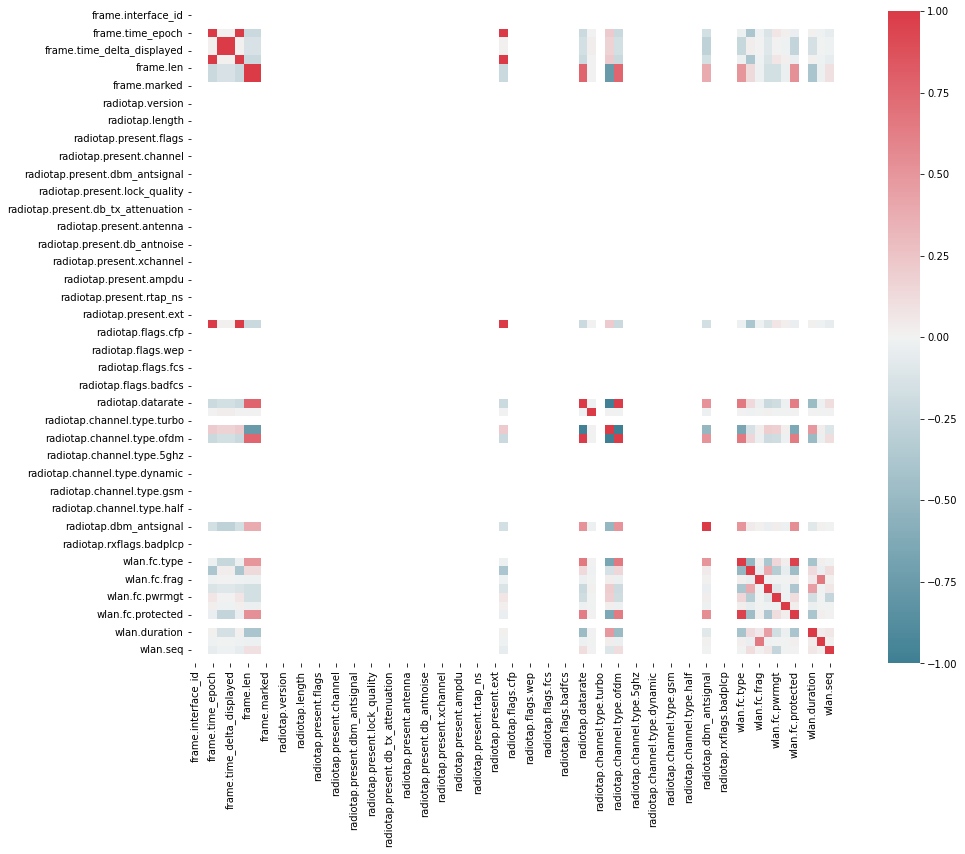

In [21]:
# run correlation matrix and plot
f, ax = plt.subplots(figsize=(16, 12))
corr = awid.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

features_corr = correlated_features(corr)

Before drop:
(782934, 83)
After drop:
(782934, 77)


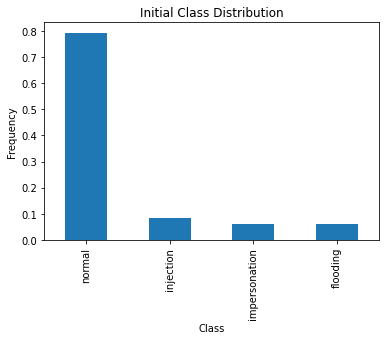

In [22]:
print("Before drop:")
print(awid.shape)

features_to_drop = ["frame.cap_len", "frame.time_delta_displayed", "frame.time_epoch", "radiotap.mactime", "radiotap.datarate", "wlan.fc.protected"]

awid.drop(features_to_drop, inplace=True, axis=1)

print("After drop:")
print(awid.shape)

class_distribution_bar(awid, "Initial Class Distribution")

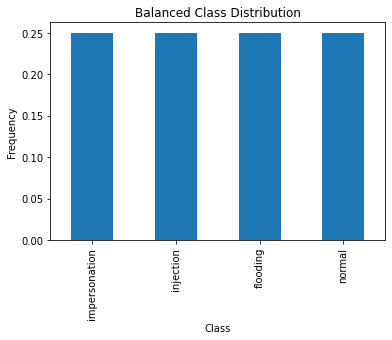

In [23]:


df = awid.sample(frac=1)


inj = df[df['class'] == 'injection']
impers = df[df['class'] == 'impersonation']
flooding = df[df['class'] == 'flooding']
normal = df[df['class'] == 'normal']


samples = min(len(inj), len(impers), len(flooding))

awid = pd.concat([inj.sample(n=samples), impers.sample(n=samples), flooding.sample(n=samples), normal.sample(n=samples)])
awid = awid.sample(frac=1).reset_index()
awid['class'].value_counts(normalize=True)

class_distribution_bar(awid, "Balanced Class Distribution")

In [24]:
print(awid.shape)
X, y = awid.select_dtypes(['number']), awid['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)


(193936, 78)


In [25]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
def model_analysis(model, X_train, y_train, X_test, y_test):

    print(f"> Model: {model.__class__}\n")
    classes = ['flooding', 'impersonating', 'injection', 'normal']
    
    X_test_prediction = model.predict(X_test)
    test_data_accuracy = accuracy_score(X_test_prediction, y_test)
    f1 = f1_score(y_test, X_test_prediction, average = None)

    print()
    print("---- Model Analysis ----")
    print('Accuracy: ', test_data_accuracy)
    print('F1 Score: ', f1)
    
    print()
    
    print("Confusion Matrix: ")
    encoder = LabelEncoder()
    y_pred = encoder.fit_transform(X_test_prediction)
    y_expected = encoder.fit_transform(y_test)

    con_mat = tf.math.confusion_matrix(labels=y_expected, predictions=y_pred).numpy()
    
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
    
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print()
    print("---- Classification Report ----")
    print(classification_report(y_test, model.predict(X_test)))

> Model: <class 'sklearn.naive_bayes.GaussianNB'>


---- Model Analysis ----
Accuracy:  0.7442507992162525
F1 Score:  [0.50204334 0.96501035 0.74373409 0.72322533]

Confusion Matrix: 


2022-06-30 16:28:50.618292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 16:28:50.619146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 16:28:50.619351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-30 16:28:50.619675: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-30 16:28:50.619796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

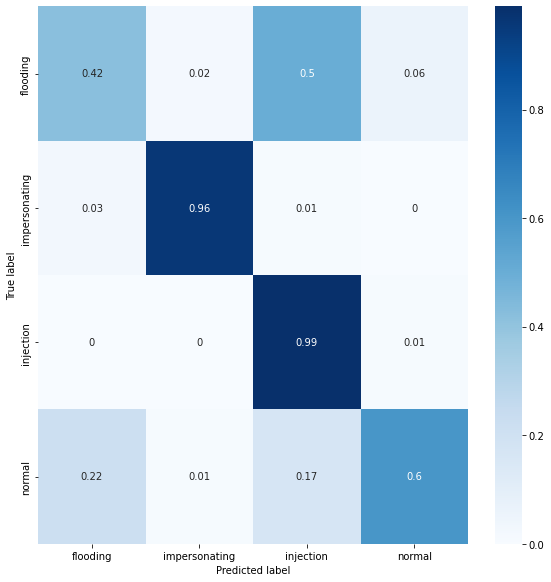


---- Classification Report ----
               precision    recall  f1-score   support

     flooding       0.63      0.42      0.50      9697
impersonation       0.97      0.96      0.97      9697
    injection       0.59      0.99      0.74      9697
       normal       0.90      0.60      0.72      9697

     accuracy                           0.74     38788
    macro avg       0.77      0.74      0.73     38788
 weighted avg       0.77      0.74      0.73     38788



In [26]:
# do a basic naive bayes fitting
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

# fit our model to the data
nb.fit(X_train, y_train)

model_analysis(nb, X_train, y_train, X_test, y_test)

/home/sousa/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


---- Model Analysis ----
Accuracy:  0.7335000515623389
F1 Score:  [0.642013   0.85611017 0.69696346 0.7264877 ]

Confusion Matrix: 


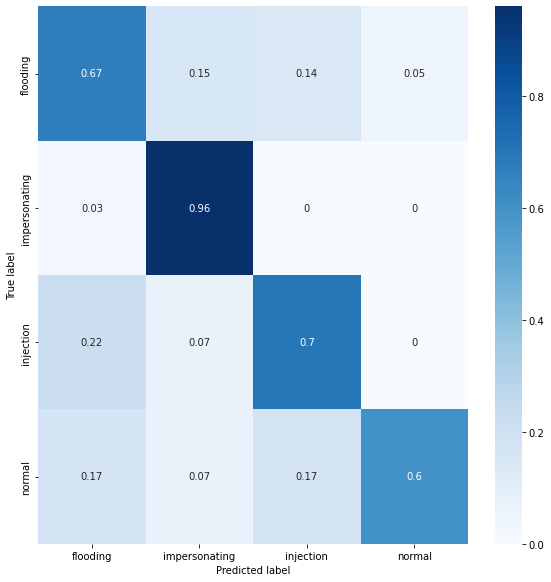


---- Classification Report ----
               precision    recall  f1-score   support

     flooding       0.61      0.67      0.64      9697
impersonation       0.77      0.96      0.86      9697
    injection       0.70      0.70      0.70      9697
       normal       0.92      0.60      0.73      9697

     accuracy                           0.73     38788
    macro avg       0.75      0.73      0.73     38788
 weighted avg       0.75      0.73      0.73     38788



In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)

model_analysis(lr, X_train, y_train, X_test, y_test)

In [29]:
# see gini scores of decision tree features
pd.DataFrame({'feature':awid.select_dtypes(['number']).columns, 
              'importance':tree.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
65,wlan.duration,0.316006
59,wlan.fc.subtype,0.282306
5,frame.len,0.178519
0,index,0.080138
61,wlan.fc.retry,0.066046
58,wlan.fc.type,0.051116
67,wlan.seq,0.019636
4,frame.time_relative,0.002867
54,radiotap.dbm_antsignal,0.002604
3,frame.time_delta,0.000763


> Model: <class 'sklearn.pipeline.Pipeline'>


---- Model Analysis ----
Accuracy:  0.9249252346086418
F1 Score:  [0.89300867 0.95573139 0.97408338 0.87498553]

Confusion Matrix: 


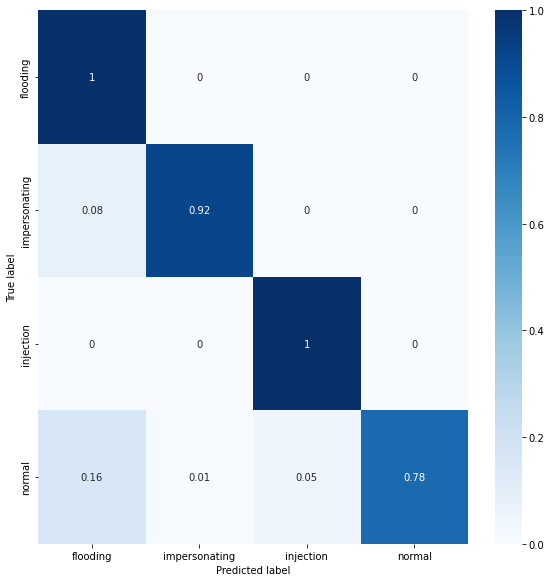


---- Classification Report ----
               precision    recall  f1-score   support

     flooding       0.81      1.00      0.89      9697
impersonation       0.99      0.92      0.96      9697
    injection       0.95      1.00      0.97      9697
       normal       1.00      0.78      0.87      9697

     accuracy                           0.92     38788
    macro avg       0.94      0.92      0.92     38788
 weighted avg       0.94      0.92      0.92     38788



In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

preprocessing = Pipeline([
    ("scale", StandardScaler()),
])

pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("classifier", RandomForestClassifier())
])

# try varying levels of depth
params = {
    "classifier__max_depth": [2, 3], 
         }

grid = GridSearchCV(pipeline, params)
grid.fit(X_train, y_train)
# best accuracy so far!
model_analysis(grid.best_estimator_, X_train, y_train, X_test, y_test)

# Deep Learning Implementation

In [33]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_y_train = encoder.fit_transform(y_train)
encoded_y_test = encoder.fit_transform(y_test)

In [34]:
def train_predict_and_save_model(model, model_name, X_train, y_train, X_test, y_test, epochs = 2, batch_size=32):
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
    
    y_hat = model.predict(X_test)
    
    return accuracy_score(encoded_y_test, y_hat)
    #model.save(model_name)
def evaluate_model(model, X_test, y_test):
    """
    evaluate model on test set and show results in dataframe.
    
    Parameters
    ----------
    model : keras model
        trained keras model.
    X_test : numpy array
        Features of holdout set.
    y_test : numpy array
        Labels of holdout set.
        
    Returns
    -------
    display_df : DataFrame
        Pandas dataframe containing evaluation results.
    """
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

In [35]:
epochs = 20

# Neural Networks

In [36]:
# Baseline model for the neural network. We choose a hidden layer of 10 neurons. The lesser number of neurons helps to eliminate the redundancies in the data and select the more important features.
def create_baseline_model(n, input_dim):
    # create model
    model = Sequential()
    model.add(Dense(n, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
KerasClassifier(build_fn=create_baseline_model, epochs=100, batch_size=5, verbose=0, n=20)

keras_model = KerasClassifier(build_fn=create_baseline_model, epochs=epochs, batch_size=128, verbose=1, n=10, input_dim=len(X_train.columns))

/tmp/ipykernel_74587/3889754841.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=create_baseline_model, epochs=100, batch_size=5, verbose=0, n=20)
/tmp/ipykernel_74587/3889754841.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=create_baseline_model, epochs=epochs, batch_size=128, verbose=1, n=10, input_dim=len(X_train.columns))


In [38]:
keras_model_accuracy = train_predict_and_save_model(keras_model, "KerasModel", X_train, encoded_y_train, X_test, encoded_y_test, epochs = epochs, batch_size = 128)

Epoch 1/20
1213/1213 [==============================] - 2s 1ms/step - loss: 54.7188 - accuracy: 0.3882
Epoch 2/20
1213/1213 [==============================] - 1s 1ms/step - loss: 9.6749 - accuracy: 0.4722
Epoch 3/20
1213/1213 [==============================] - 1s 1ms/step - loss: 7.2791 - accuracy: 0.5821
Epoch 4/20
1213/1213 [==============================] - 1s 1ms/step - loss: 6.3017 - accuracy: 0.6252
Epoch 5/20
1213/1213 [==============================] - 1s 1ms/step - loss: 5.5915 - accuracy: 0.6589
Epoch 6/20
1213/1213 [==============================] - 1s 1ms/step - loss: 4.9027 - accuracy: 0.6842
Epoch 7/20
1213/1213 [==============================] - 1s 1ms/step - loss: 4.3830 - accuracy: 0.7099
Epoch 8/20
1213/1213 [==============================] - 1s 1ms/step - loss: 3.7118 - accuracy: 0.7305
Epoch 9/20
1213/1213 [==============================] - 1s 1ms/step - loss: 3.0194 - accuracy: 0.7544
Epoch 10/20
1213/1213 [==============================] - 1s 1ms/step - loss: 2.83

In [39]:
def build_model(hp):
    """
    Builds model and sets up hyperparameter space to search.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_dim=(len(X_train.columns))))
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=4, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [40]:
import kerastuner as kt

tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory="kt_dir",
                     project_name="kt_hyperband",)

INFO:tensorflow:Reloading Oracle from existing project kt_dir/kt_hyperband/oracle.json


/tmp/ipykernel_74587/1370665737.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


INFO:tensorflow:Reloading Tuner from kt_dir/kt_hyperband/tuner0.json


In [41]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_3 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_4 (Int)
{'defau

In [42]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [43]:
tuner.search(X_train, encoded_y_train, epochs=epochs, validation_split=0.2, callbacks=[stop_early], verbose=2)

INFO:tensorflow:Oracle triggered exit


In [44]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

In [45]:
# Build model
h_model = tuner.hypermodel.build(best_hps)

In [48]:
history = h_model.fit(X_train, encoded_y_train, epochs=50, validation_split=0.2, callbacks=[stop_early], verbose=2)

Epoch 1/50
3879/3879 - 6s - loss: 0.2333 - accuracy: 0.9230 - val_loss: 0.0951 - val_accuracy: 0.9715 - 6s/epoch - 2ms/step
Epoch 2/50
3879/3879 - 6s - loss: 0.2009 - accuracy: 0.9341 - val_loss: 0.0981 - val_accuracy: 0.9776 - 6s/epoch - 2ms/step
Epoch 3/50
3879/3879 - 6s - loss: 0.1855 - accuracy: 0.9397 - val_loss: 0.1371 - val_accuracy: 0.9622 - 6s/epoch - 2ms/step
Epoch 4/50
3879/3879 - 6s - loss: 0.1811 - accuracy: 0.9405 - val_loss: 0.0657 - val_accuracy: 0.9772 - 6s/epoch - 2ms/step
Epoch 5/50
3879/3879 - 6s - loss: 0.2294 - accuracy: 0.9218 - val_loss: 0.0838 - val_accuracy: 0.9757 - 6s/epoch - 2ms/step
Epoch 6/50
3879/3879 - 6s - loss: 0.2053 - accuracy: 0.9319 - val_loss: 0.0703 - val_accuracy: 0.9802 - 6s/epoch - 2ms/step
Epoch 7/50
3879/3879 - 6s - loss: 0.1810 - accuracy: 0.9403 - val_loss: 0.0765 - val_accuracy: 0.9844 - 6s/epoch - 2ms/step
Epoch 8/50
3879/3879 - 7s - loss: 0.1802 - accuracy: 0.9411 - val_loss: 0.0598 - val_accuracy: 0.9861 - 7s/epoch - 2ms/step
Epoch 9/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


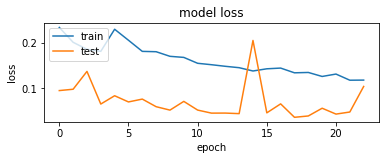

In [50]:
print(history.history.keys())


plt.legend(['train', 'test'], loc='upper left')  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [55]:
def deep_learning_model_analysis(model, X_train, y_train, X_test, y_test):

    print(f"> Model: {model.__class__}\n")
    classes = ['flooding', 'impersonating', 'injection', 'normal']
    y_pred=model.predict(X_test)
    pred = []
    for j in y_pred:
        greater = j[0]
        index = 0
        for y in range(1,4):
            if greater < j[y]:
                greater = j[y]
                index = y
        pred.append(index)
    y_pred = pred
    test_data_accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_test, y_pred, average = None)

    print()
    print("---- Model Analysis ----")
    print('Accuracy: ', test_data_accuracy)
    print('F1 Score: ', f1)
    
    print()
    
    print("Confusion Matrix: ")

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
    
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
    
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


> Model: <class 'keras.engine.sequential.Sequential'>

1213/1213 [==============================] - 1s 1ms/step

---- Model Analysis ----
Accuracy:  0.9652212024337424
F1 Score:  [0.96578856 0.95021175 0.99033199 0.95383125]

Confusion Matrix: 


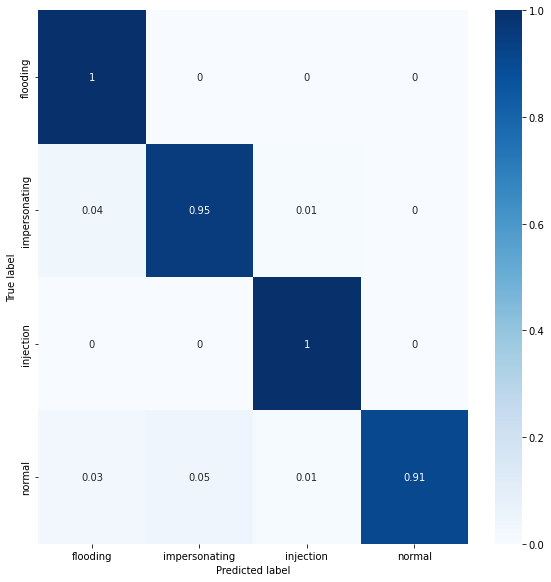

In [56]:
deep_learning_model_analysis(h_model, X_train, encoded_y_train, X_test, encoded_y_test)

In [49]:
#Save model on file
h_model.save("HypertunedModel")

INFO:tensorflow:Assets written to: HypertunedModel/assets


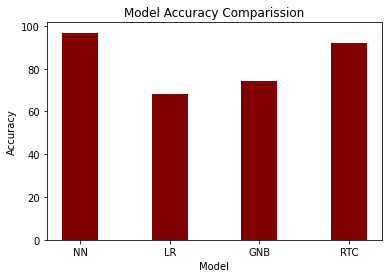

In [46]:
data = {
    "NN": 96.84,
    "LR": 68.40,
    "GNB":74.44,
    "RTC":92.13 
}


plt.bar(data.keys(), data.values(), color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparission")
plt.show()

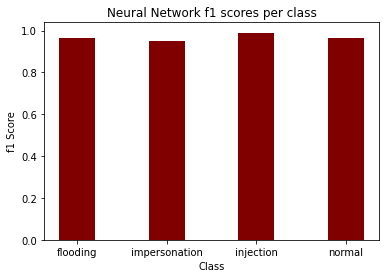

In [47]:
data = {
    "flooding": 0.965,
    "impersonation": 0.950,
    "injection": 0.990,
    "normal": 0.963
}

plt.bar(data.keys(), data.values(), color ='maroon',
        width = 0.4)
 
plt.xlabel("Class")
plt.ylabel("f1 Score")
plt.title("Neural Network f1 scores per class")
plt.show()